Training set shape: (1007, 20)
Test set shape: (252, 20)
Number of features: 20
Target distribution in training set:
target
1    509
0    498
Name: count, dtype: int64
Models to train: ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost', 'Decision Tree', 'SVM', 'Naive Bayes']

Training Logistic Regression...
✅ Logistic Regression completed - Test Accuracy: 0.7302

Training Random Forest...
✅ Random Forest completed - Test Accuracy: 0.7222

Training Gradient Boosting...
✅ Gradient Boosting completed - Test Accuracy: 0.7103

Training XGBoost...
✅ XGBoost completed - Test Accuracy: 0.7183

Training LightGBM...
✅ LightGBM completed - Test Accuracy: 0.7103

Training CatBoost...
✅ CatBoost completed - Test Accuracy: 0.7222

Training Decision Tree...
✅ Decision Tree completed - Test Accuracy: 0.6548

Training SVM...
✅ SVM completed - Test Accuracy: 0.7381

Training Naive Bayes...
✅ Naive Bayes completed - Test Accuracy: 0.7421

🎉 All models trained 

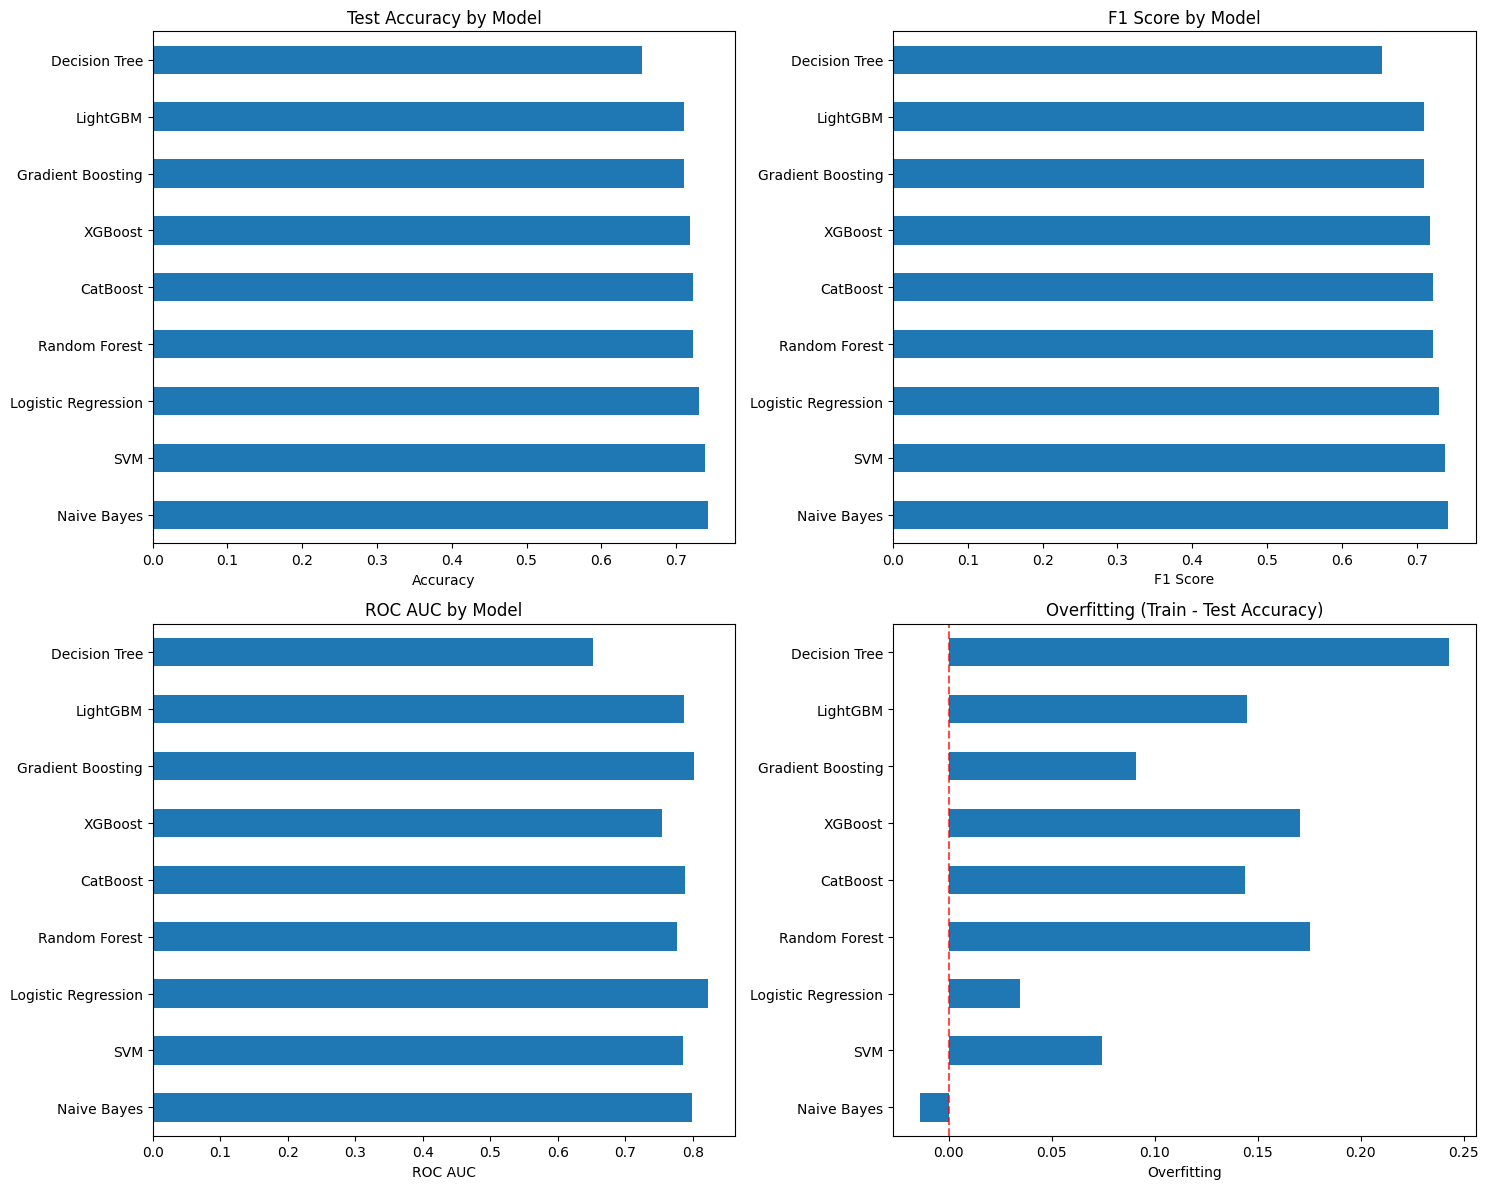

DETAILED EVALUATION OF Naive Bayes:
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       124
           1       0.77      0.70      0.73       128

    accuracy                           0.74       252
   macro avg       0.74      0.74      0.74       252
weighted avg       0.74      0.74      0.74       252



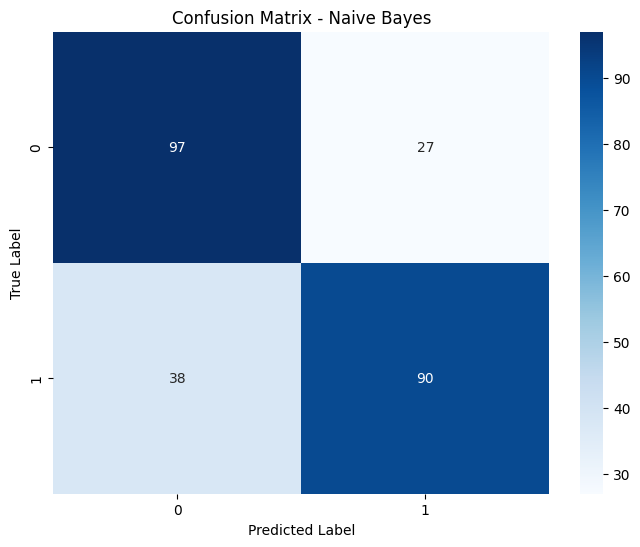

In [1]:
# model_training.py

# =========================
# Model Training and Evaluation
# =========================
# This script trains multiple machine learning models to predict mental health treatment seeking behavior.

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Advanced models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)

# Model interpretation
import shap

# -------------------------
# Load processed data
# -------------------------
train_data = pd.read_csv('../data/processed/train_data.csv')
test_data = pd.read_csv('../data/processed/test_data.csv')

# Load selected features
with open('../data/processed/selected_features.json', 'r') as f:
    selected_features = json.load(f)

# Separate features and target
X_train = train_data[selected_features]
y_train = train_data['target']
X_test = test_data[selected_features]
y_test = test_data['target']

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of features: {len(selected_features)}")
print(f"Target distribution in training set:")
print(y_train.value_counts())

# -------------------------
# Define models to train
# -------------------------
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=False),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB()
}

print(f"Models to train: {list(models.keys())}")

# -------------------------
# Train and evaluate models
# -------------------------
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Get prediction probabilities
    if hasattr(model, 'predict_proba'):
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_test_proba = None
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # ROC AUC if probabilities available
    roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
    
    # Store results
    results[name] = {
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Overfitting': train_accuracy - test_accuracy
    }
    
    # Store trained model
    trained_models[name] = model
    
    print(f"✅ {name} completed - Test Accuracy: {test_accuracy:.4f}")

print("\n🎉 All models trained successfully!")

# -------------------------
# Create results comparison DataFrame
# -------------------------
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("MODEL PERFORMANCE COMPARISON:")
print("=" * 60)
print(results_df)

# Identify best model
best_model_name = results_df.index[0]
best_model = trained_models[best_model_name]
print(f"\n🏆 Best Model: {best_model_name}")
print(f"Best Test Accuracy: {results_df.loc[best_model_name, 'Test Accuracy']:.4f}")

# -------------------------
# Visualize model performance
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Test Accuracy
results_df['Test Accuracy'].plot(kind='barh', ax=axes[0,0])
axes[0,0].set_title('Test Accuracy by Model')
axes[0,0].set_xlabel('Accuracy')

# F1 Score
results_df['F1 Score'].plot(kind='barh', ax=axes[0,1])
axes[0,1].set_title('F1 Score by Model')
axes[0,1].set_xlabel('F1 Score')

# ROC AUC (excluding models without probabilities)
roc_data = results_df['ROC AUC'].dropna()
if not roc_data.empty:
    roc_data.plot(kind='barh', ax=axes[1,0])
    axes[1,0].set_title('ROC AUC by Model')
    axes[1,0].set_xlabel('ROC AUC')

# Overfitting analysis
results_df['Overfitting'].plot(kind='barh', ax=axes[1,1])
axes[1,1].set_title('Overfitting (Train - Test Accuracy)')
axes[1,1].set_xlabel('Overfitting')
axes[1,1].axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# -------------------------
# Detailed evaluation of best model
# -------------------------
print(f"DETAILED EVALUATION OF {best_model_name}:")
print("=" * 60)

best_y_pred = best_model.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, best_y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, best_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
